# Performance improvement of Aer primitives

- Name: Ikko Hamamura
- Affiliation: IBM Quantum, IBM Research - Tokyo
- Researcher
- Qiskit Advocate
- Qiskit core developer

## What is primitives?

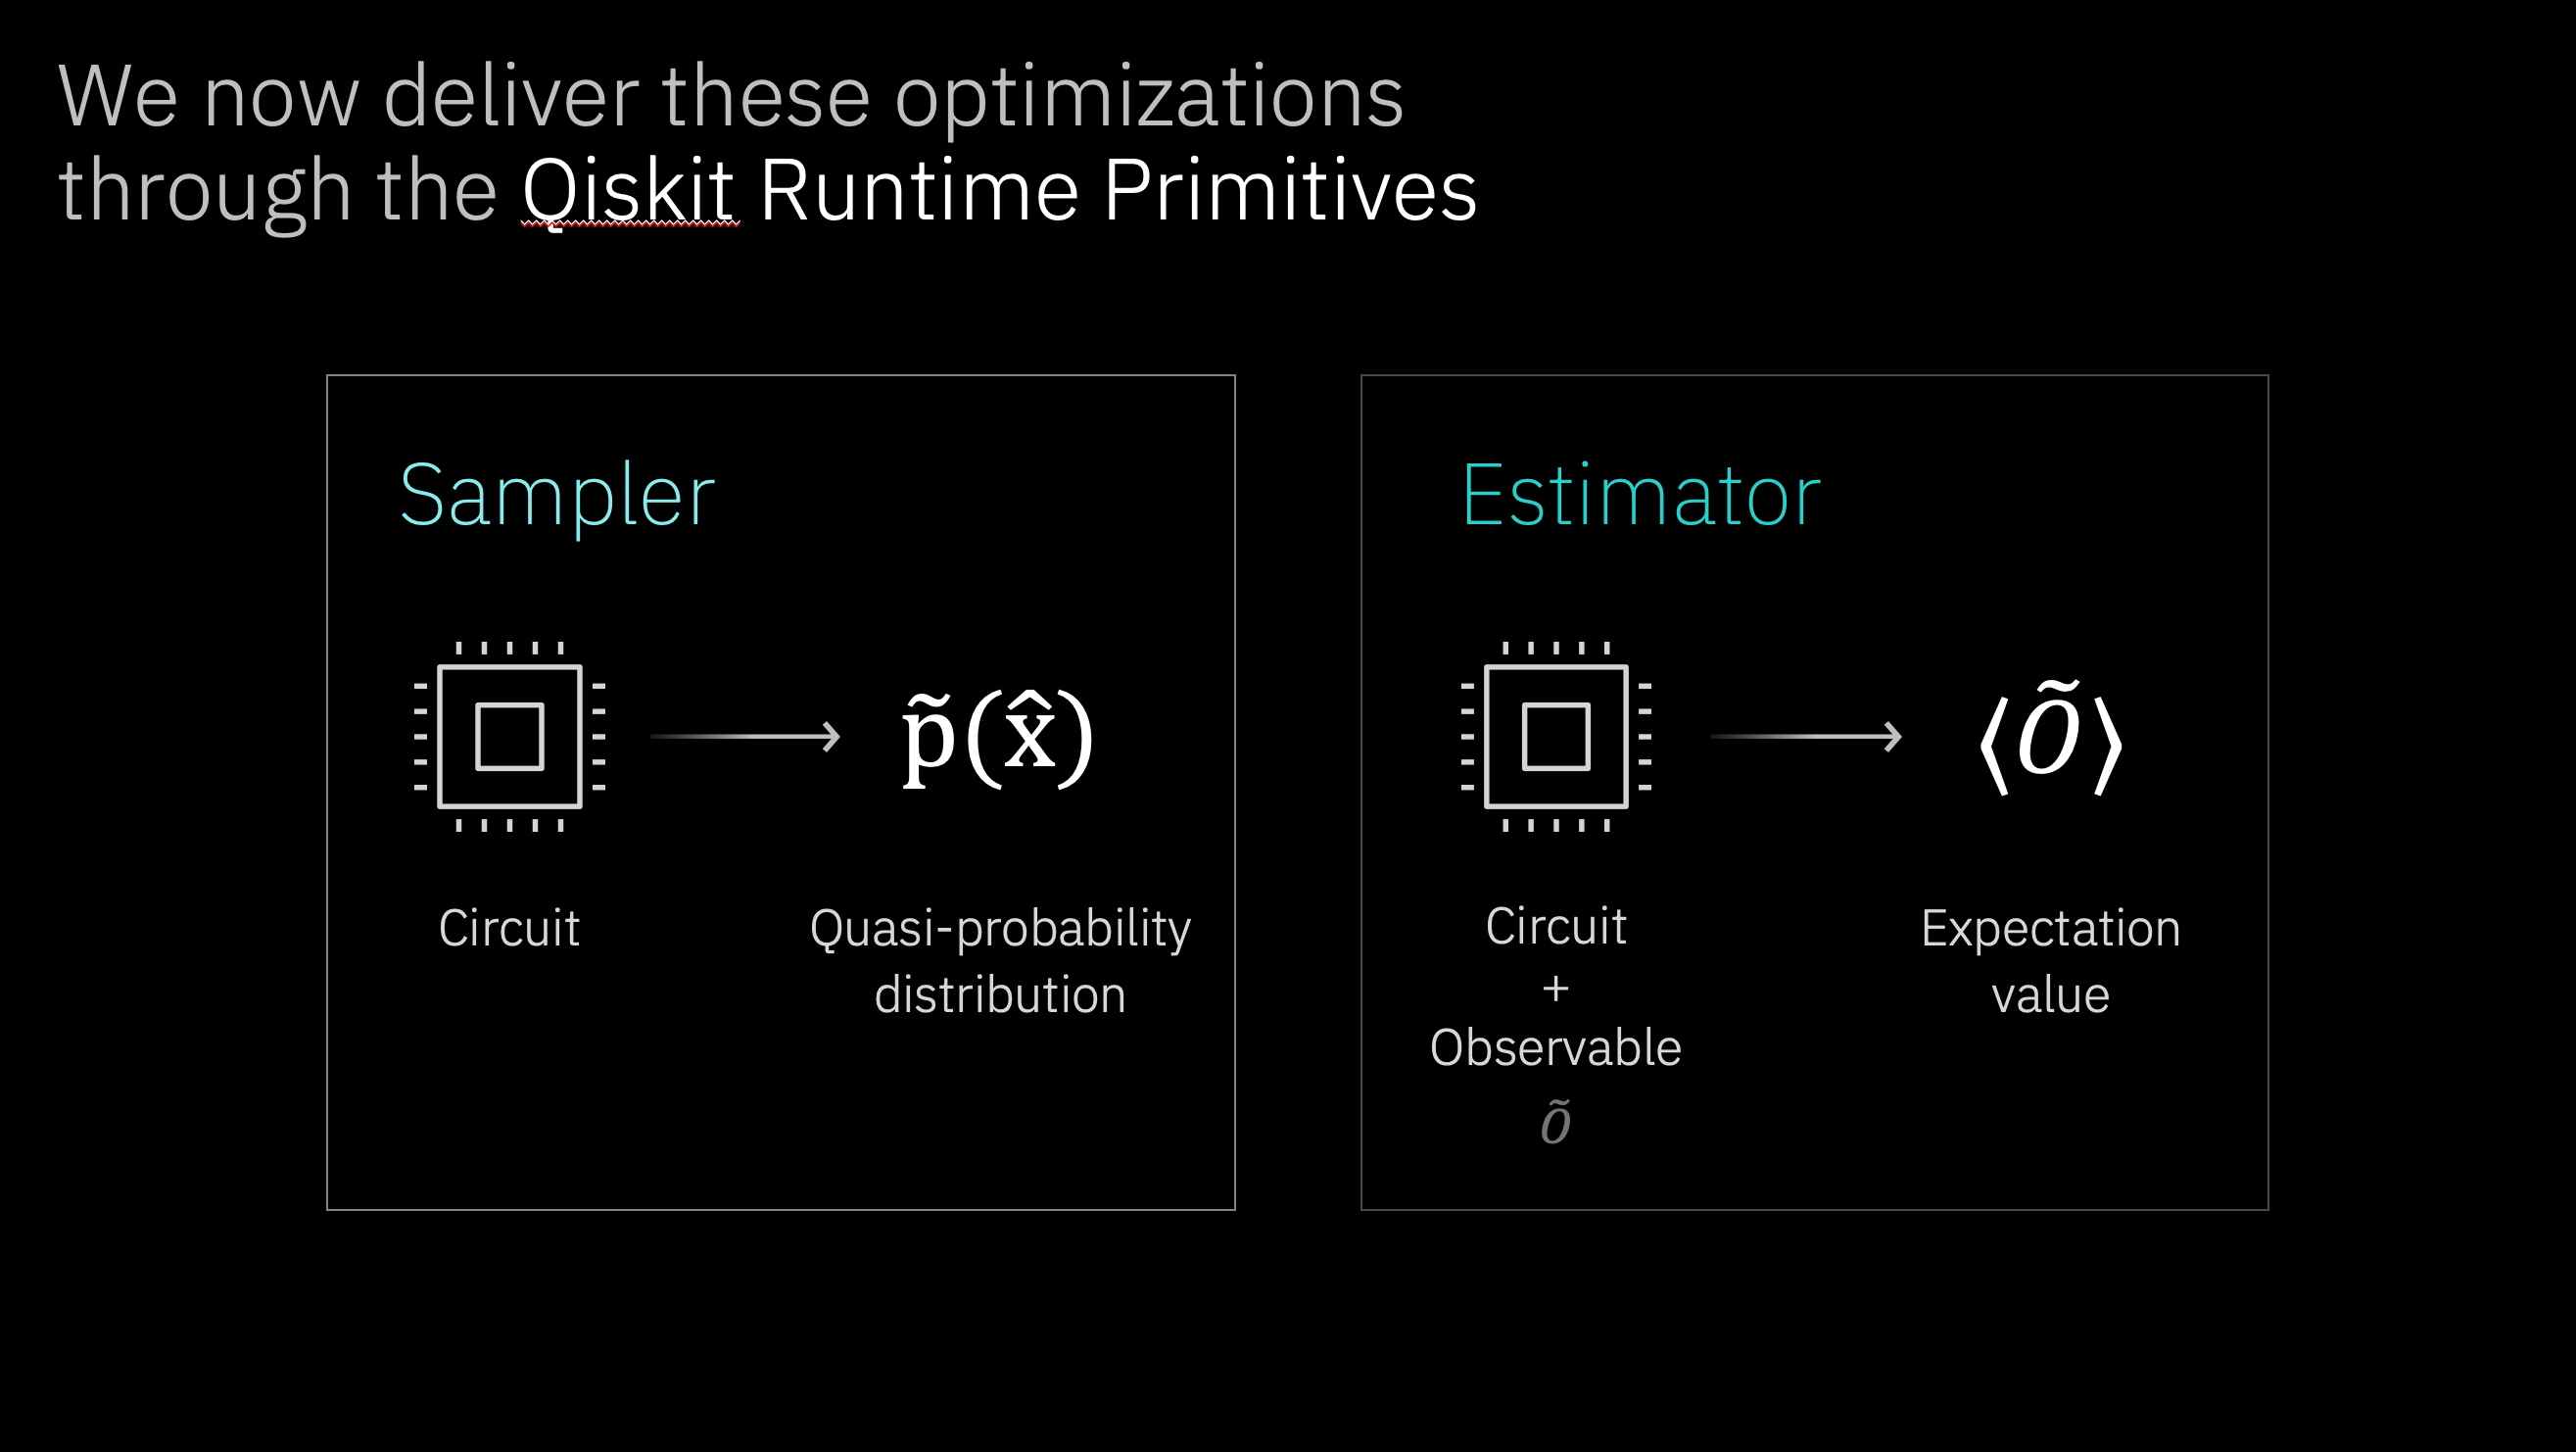


Cited from [IBM Quantum State of the Union 2022](https://www.youtube.com/watch?v=nZu5hutqANk) in IBM Quantum Summit 2022: https://www.ibm.com/quantum/summit

To learn primitives more, check primitives tutorial (under review) https://github.com/Qiskit/qiskit-tutorials/pull/1385!

## Previous talks related to primitives (from algorithmic perspective)

### Oct 13, 2022

- dlasecki: Time evolution algorithm on primitives

### Sep 29, 2022

- a-matsuo: Gradients on primitives - https://github.com/Qiskit/qiskit-terra/pull/8528
- Declan: VQE on primitives - https://github.com/Qiskit/qiskit-terra/pull/8702 https://github.com/Qiskit/qiskit-terra/pull/8669

### Sep 15, 2022

- ElePT: Fidelity interface using primitives - https://github.com/Qiskit/qiskit-terra/pull/8303

## Aer primitives

- High performance (C++) local simulator of primitives.

In [6]:
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=2)
observable = SparsePauliOp.from_list([("XX", 1), ("YY", 2), ("ZZ", 3)])

estimator = Estimator()
result = estimator.run(ansatz, observable, parameter_values=[0, 1, 1, 2, 3, 5]).result()
print("Expectation value:", result.values)

Expectation value: [1.77148438]


## approximation option (Estimator)

### Estimator's argument

- approximation (bool) – If True, it calculates expectation values with normal distribution approximation.
- If `shots` is `None` (Default), estimator computes exact expectation value (no sampling error).
- This option is similar to `AerPauliExpectation` in opflow.

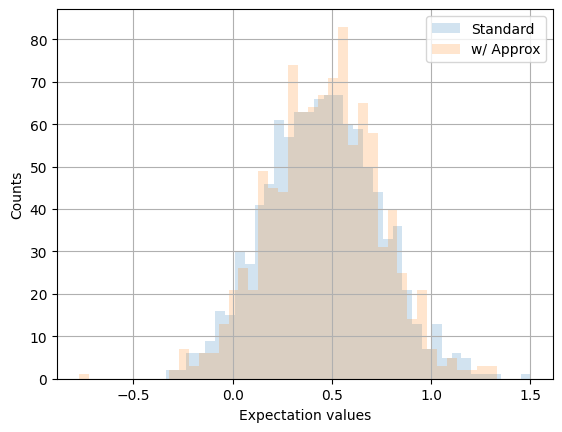

In [8]:
estimator = Estimator(approximation=True)
result = estimator.run(ansatz, observable, parameter_values=[0, 1, 1, 2, 3, 5]).result()
print("Expectation value:", result.values)

Expectation value: [1.84209213]


## Add abelian_grouping to Estimator [#1716](https://github.com/Qiskit/qiskit-aer/pull/1716)


- This option is similar to `AbelianGrouper` in opflow.
- Commutative (Abelian) observables are jointly measureble.
- e.g.) ["ZIZ", "IZZ", "ZZZ", ...]

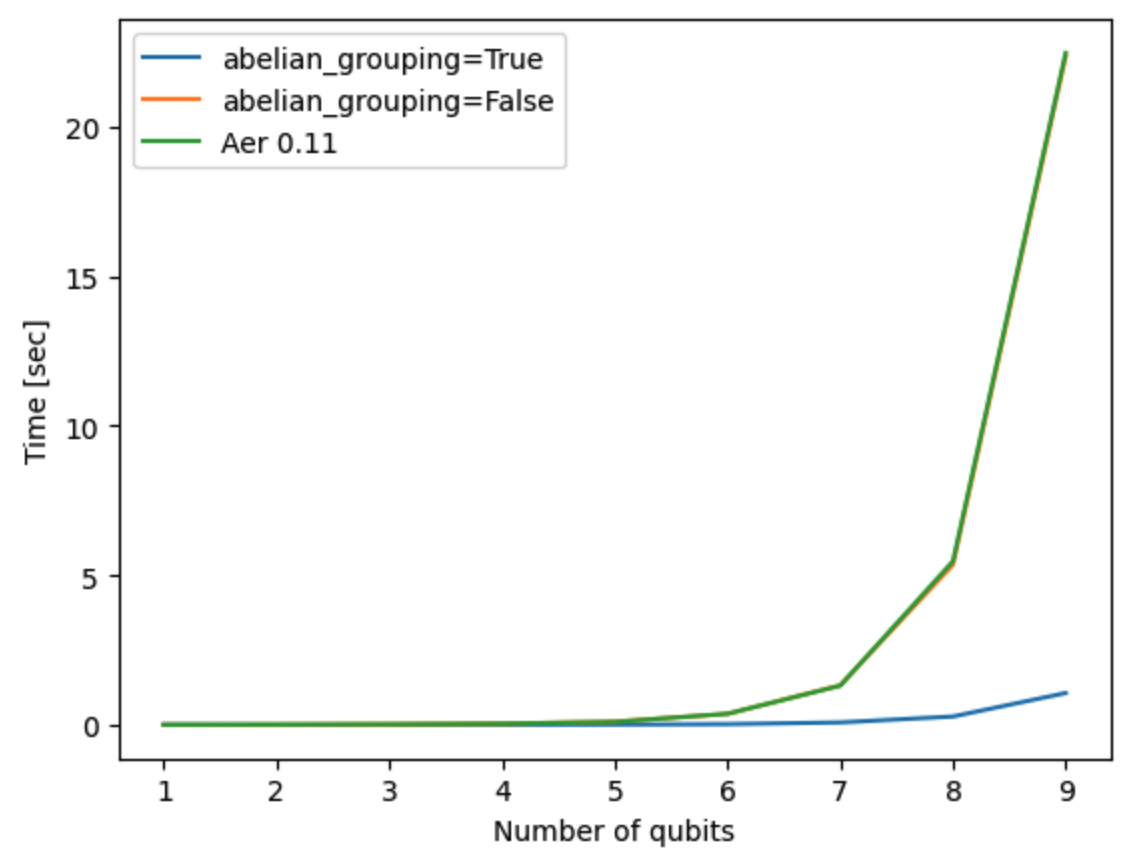

In [11]:
from itertools import product
import numpy as np

num_qubits = 8
abelian_grouping = True

ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)
observables = [
    SparsePauliOp("".join(pauli_str)) for pauli_str in product("IZ", repeat=num_qubits)
]
parameter_values = list(np.random.rand(1, ansatz.num_parameters))
estimator = Estimator(abelian_grouping=abelian_grouping)

In [12]:
%%time
result = estimator.run(
    circuits=[ansatz] * len(observables),
    observables=observables,
    parameter_values=parameter_values * len(observables),
).result()

CPU times: user 316 ms, sys: 6.06 ms, total: 322 ms
Wall time: 327 ms


In [15]:
# opflow and estimator can group
SparsePauliOp(["XX", "XI"])

SparsePauliOp(['XX', 'XI'],
              coeffs=[1.+0.j, 1.+0.j])

In [14]:
# Estimator can group
[SparsePauliOp("XX"), SparsePauliOp("XI")]

(SparsePauliOp(['XX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['XI'],
               coeffs=[1.+0.j]))

### Simulate QuantumCircuit without QObj [#1717](https://github.com/Qiskit/qiskit-aer/pull/1717) (Horii-san)

- Problem: `assemble()` is slow.
- Previous flow: assemble: `QuantumCircuit` -> `QObj`
- New flow: `QuantumCircuit` -> `AER::Circuit`/`AerCircuit` (C++ native class/its Python wrapper)

## Benchmark for VQE

- VQE utilizes Estimator
- `approximation=True, shots=None`

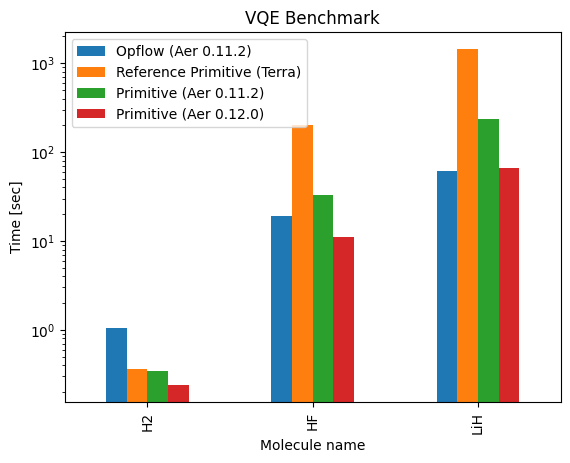

## Benchmark for QSVC (Quantum Support Vector Classifier)

- QSVC utilizes sampler.

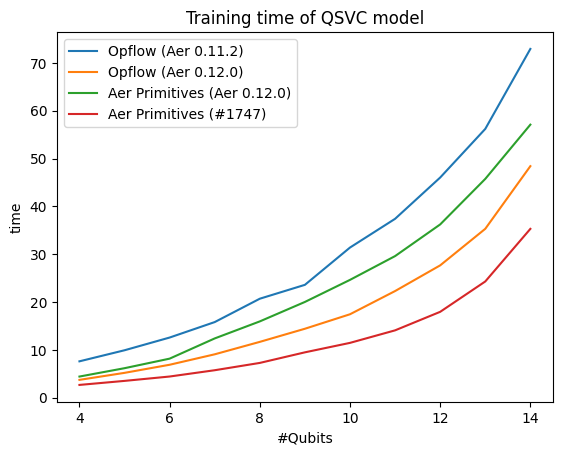